# Multilabel and multiclass classification with CNN and pre-trained word embeddings

#### Aaron Anderson

This notebook presents a working example of a classification problem using a convolutional neural network architecture that exploits pre-trained word embeddings from Google's word2vec.

---
### 1. Imports

In [2]:
import numpy as np
import pandas as pd
import string
import os
import csv
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, Flatten
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, svm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.keyedvectors import KeyedVectors


Using TensorFlow backend.


---
### 2. Load labeled data

In [3]:
df = pd.read_excel('Broad Identity Catergories.xlsx', header=2, dtype={'user_desc': str})
df.head()

,Unnamed: 0,user_desc,Unnamed: 2,Age,Location,"Male, He,Him, man","Female, She, Her, woman","They, Them","Republican, (Pro) Conservative, Anti-Liberal, Right","Democrat, (Pro) Liberal, Anti-Conservative, Left",...,Artist,Journalism and Media Communication,Legal,Natural Resources,History/Cultural Studies,Sports.1,Animal Science,Criminal Justice/Political Science,Thespian,Other
0,control,11th Gen. Cdn. (1653) Conservative. Retired sm...,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,concern,She/Her ~ Somewhere on the ace/aro spectrum ~ ...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,info,Like all of my tweets are going to be video g...,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,concern,"Female dairy farmer (4th generation), assistan...",1,NaN,New York,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,concern,Reporter @washingtonpost. Formerly at @starsan...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 0', 'Unnamed: 2', 'Age', 'Location', 'Unnamed: 76', 'Unnamed: 20',
              'Unnamed: 21',], axis=1)
df[list(df)[1:]] = df[list(df)[1:]].fillna(0)

In [4]:
print(f'The data has {df.shape[0]} rows.')

The data has 1363 rows.


In [5]:
list(df)

['user_desc',
 'Male, He,Him, man',
 'Female, She, Her, woman',
 'They, Them',
 'Republican, (Pro) Conservative, Anti-Liberal, Right',
 'Democrat, (Pro) Liberal, Anti-Conservative, Left',
 'Libertarian ',
 'Pro-Trump, Pro-MAGA',
 'Anti-Trump, Anti-MAGA',
 'Socialist',
 'Centrist ',
 'NRA',
 'USDA',
 'NRCS',
 'WS',
 'University Affliate ',
 'Married',
 'Husband',
 'Wife',
 'Parent',
 'Mom, Mother',
 'Dad,Father',
 'Grandma/mother',
 'Grandpa/father',
 'Christian ',
 'Muslim',
 '"Religious"/ "In God We Trust"/ "Bible Verse"',
 'Catholic',
 'Buddhist',
 'Lutheran ',
 'Atheist ',
 'Other ',
 'Gay',
 'Bi-sexual',
 'Queer',
 'Lesbian ',
 'Straight',
 'Transgender',
 'Pansexual ',
 'Asexual ',
 'Latino',
 'Black/Africian ',
 'White',
 'Asian',
 'European',
 'Native American',
 'Animal Lover/Advocate',
 'Blogger',
 'Geek/Nerd',
 'Vegan/Vegetarian ',
 'American',
 'Texan',
 'Gear',
 'Outdoorsman/woman',
 'Canadian ',
 'Angler',
 'Hunter',
 'Sports',
 'Politics',
 'Science',
 'Feminism/ist',
 'C

In [6]:
df.head()

,user_desc,"Male, He,Him, man","Female, She, Her, woman","They, Them","Republican, (Pro) Conservative, Anti-Liberal, Right","Democrat, (Pro) Liberal, Anti-Conservative, Left",Libertarian,"Pro-Trump, Pro-MAGA","Anti-Trump, Anti-MAGA",Socialist,...,Artist,Journalism and Media Communication,Legal,Natural Resources,History/Cultural Studies,Sports.1,Animal Science,Criminal Justice/Political Science,Thespian,Other
0,11th Gen. Cdn. (1653) Conservative. Retired sm...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,She/Her ~ Somewhere on the ace/aro spectrum ~ ...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Like all of my tweets are going to be video g...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Female dairy farmer (4th generation), assistan...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Reporter @washingtonpost. Formerly at @starsan...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
new_map = {
    'Parent': ['Mom, Mother', 'Dad,Father', 'Grandma/mother','Grandpa/father', 'Parent'],
    'Spouse': ['Married', 'Husband', 'Wife'],
    'Male': ['Male, He,Him, man'],
    'Female': ['Female, She, Her, woman'],
    'They': ['They, Them'],
    'Conservative Ideology': ['Republican, (Pro) Conservative, Anti-Liberal, Right'],
    'Liberal Ideology': ['Democrat, (Pro) Liberal, Anti-Conservative, Left'],
    'White': ['White'],
    'Asian': ['Asian'],
    'Native American': ['Native American'],
    'Black/African American': ['Black/Africian '],
    'Latino': ['Latino'],
    'LGBTQ': ['Gay', 'Lesbian ', 'Transgender', 'Bi-sexual', 'Queer'],
    'Religious': ['"Religious"/ "In God We Trust"/ "Bible Verse"', 'Christian ', 'Catholic'],
    'Pro-Environment': ['Pro-Climate/Environmentalist/Pro-Earth/Nature'],
    'Anti-Environment': ['Anti-Climate/Environmentalist'],
    'Animal Advocate': ['Animal Lover/Advocate', 'Vegan/Vegetarian '],
    'Outdoorsman/women': ['Outdoorsman/woman', 'Angler', 'Hunter'],
    'Pro-Guns': ['NRA', 'Pro-Gun'],
    'Politics': ['Politics'],
    'Government Organizations': ['USDA','NRCS', 'WS'],
    'Pro-Trump': ['Pro-Trump, Pro-MAGA'],
    'Anti-Trump': ['Anti-Trump, Anti-MAGA'],
    'Wild pigs': ['Wild Pigs'],
    'Academic': ['University Affliate ', 'Academic'],
    'Business and Computers': ['Business Admin', 'Computer Science'],
    'Criminal Justice, Political Science, and Legal Aid': ['Criminal Justice/Political Science ', 'Legal'],
    'Journalism and Media Communication': ['Journalism and Media Communication'],
    'Life & Natural Science': ['Natural Sciences', 'Animal Science'],
    'Healthcare': ['Health Care'],
    'Armed Forces': ['Armed Forces'],
    'Natural Resources': ['Natural Resources'],
    'Agriculture': ['Agriculture']
}

In [8]:
for key in list(new_map.keys()):
    df[key] = df[new_map[key]].max(axis=1)
    
columns = list(new_map.keys())

In [9]:
unique_topics = columns

In [10]:
for col in columns:
    print(f'{col}: {round(df[col].sum() / df.shape[0], 2)}')

Parent: 0.04
Spouse: 0.03
Male: 0.05
Female: 0.06
They: 0.02
Conservative Ideology: 0.01
Liberal Ideology: 0.01
White: 0.0
Asian: 0.0
Native American: 0.0
Black/African American: 0.0
Latino: 0.0
LGBTQ: 0.02
Religious: 0.02
Pro-Environment: 0.02
Anti-Environment: 0.0
Animal Advocate: 0.04
Outdoorsman/women: 0.01
Pro-Guns: 0.01
Politics: 0.01
Government Organizations: 0.0
Pro-Trump: 0.01
Anti-Trump: 0.0
Wild pigs: 0.0
Academic: 0.04
Business and Computers: 0.02
Criminal Justice, Political Science, and Legal Aid: 0.01
Journalism and Media Communication: 0.06
Life & Natural Science: 0.01
Healthcare: 0.01
Armed Forces: 0.01
Natural Resources: 0.02
Agriculture: 0.01


In [11]:
category = np.array(df[columns])
texts = np.array(df['user_desc'].astype(str))

In [12]:
np.mean(category)

0.01723026301162765

---
### 3. Functions for data organization

In [13]:
def split_sample(category, texts, val_start, val_end):
    """ Splits both sentiment and texts arrays into validation and train arrays. """
    
    category_val = category[val_start:val_end + 1, :]
    texts_val = texts[val_start:val_end + 1]
    category_train = np.delete(category, range(val_start, val_end + 1), axis=0)
    texts_train = np.delete(texts, range(val_start, val_end + 1))
    
    return category_val, texts_val, category_train, texts_train

In [14]:
def y_to_int(category_val, category_train, label_dict):
    """ Convert y vectors to 0, 1 vectors. """
    #le = preprocessing.LabelEncoder()
    #full_set = np.concatenate([category_val, category_train])
    #le.fit(full_set)
    #labels_val = le.transform(category_val)
    #labels_train = le.transform(category_train)
    
    labels_val = np.zeros(len(category_val), dtype=np.int8)
    labels_train = np.zeros(len(category_train), dtype=np.int8)
    
    for i in range(len(category_val)):
        labels_val[i] = label_dict[category_val[i]]
    for i in range(len(category_train)):
        labels_train[i] = label_dict[category_train[i]]
           
    
    return labels_val, labels_train

In [15]:
def get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH):
    """ Build bow matrix from x data. """
    x_train_bow = np.zeros((x_train.shape[0], NUM_WORDS + 1))
    x_val_bow = np.zeros((x_val.shape[0], NUM_WORDS + 1))

    for i in range(x_train.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_train_bow[i, x_train[i, j]] = 1

    for i in range(x_val.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_val_bow[i, x_val[i, j]] = 1
            
    return x_val_bow, x_train_bow

In [16]:
def build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH=None):
    """ Get sequences associated with rows (integer number of words). """
    tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True)
    tokenizer.fit_on_texts(texts_train)
    sequences_train = tokenizer.texts_to_sequences(texts_train)
    if texts_val is not None:
        sequences_val = tokenizer.texts_to_sequences(texts_val)
    
    if MAX_SEQUENCE_LENGTH is None:
        MAX_SEQUENCE_LENGTH = 0
        for sequence in sequences_train:
            if len(sequence) > MAX_SEQUENCE_LENGTH:
                MAX_SEQUENCE_LENGTH = len(sequence)
        # print('Max sequence len =', MAX_SEQUENCE_LENGTH)
    
    word_index = tokenizer.word_index
    # print('Found %s unique tokens' % len(word_index))

    data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
    if texts_val is not None:
        data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
    else:
        data_val = None
    
    return data_val, data_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer

---
### 4. Functions to get word embeddings

Consider the phrases 'have a good time' and 'have a great time'. We need some way to represent these numerically. One-hot encoding based on bag-of-words (BOW) is a conventional technique. In this example, our BOW is `(have, a, good, great, time)`. If we represent a single word with a vector of these elements we would have: <br>
* `[1, 0, 0, 0, 0]` for 'have'
* `[0, 0, 1, 0, 0]` for 'good'
* `[0, 0, 0, 1, 0]` for 'great'

The shortcoming of this representation is that the distance (in 5-dimensional space) between 'have' and 'good' is exactly the same as the distance between 'good' and 'great'. Yet we know that 'have' and 'good' have very different meanings and 'good' and 'great' have very similar meanings.  

What we would like is a vector representation of a word that is similar to the vectors that represent different words that appear in similar contexts. Google's Word2Vec is a method to construct these vectors. Consider the following neural network architecture:

<img src="images/Skipgram.png" alt="Drawing" style="width: 500px;"/>

The input is a one-hot vector for 'good', and the output is series of one-hot vectors for context words. Essentially, we are feeding the network a target word and predicting context information. If we were to train this network on large amounts of written text, it would learn the vector representation of each target word. In fact, the vector representation (the embedding) is the vector __h__ associated with the word. Since words with similar meanings tend to appear in similar contexts, the embeddings for similar words will be similar vectors.

In [17]:
def get_embedding_index(glove=True):

    if glove:
        GLOVE_DIR = '../classify-text/embeddings/glove.twitter.27B'
        embeddings_index = {}
        f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    else:
        filepath = "../Data/embeddings/GoogleNews-vectors-negative300.bin"
        embeddings_index = {}
        wv_from_bin = KeyedVectors.load_word2vec_format(filepath, binary=True) 
        for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
            coefs = np.asarray(vector, dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [18]:
def get_embedding_matrix(EMBEDDING_DIM, word_index, embeddings_index):

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # print(embedding_matrix.shape)
    return embedding_matrix

---
### 5. Functions for evaluating simple algorithms

In [19]:
def get_rf_acc(x_train_bow, y_train, x_val_bow, y_val):

    clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=500, min_samples_split=4))
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)

    y_pred_val = clf.predict(x_val_bow)
    
    exact_match_ratio = accuracy_score(y_val, y_pred_val)
    acc = np.mean(y_val == y_pred_val)
    
    print(f'RF validation accuracy = {round(acc, 3)} and exact match ratio = {round(exact_match_ratio, 3)}')
    
    return acc, exact_match_ratio

In [20]:
def get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=x_train_bow.shape[1]))
    model.add(Dropout(0.50))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(unique_topics), activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train_bow, y_train,
              batch_size=1280,
              epochs=125,
              validation_data=(x_val_bow, y_val),
              verbose=False)
    
    y_pred_val = model.predict(x_val_bow)
    
    exact_match_ratio = accuracy_score(y_val == 1., y_pred_val.round() == 1.)
    acc = np.mean((y_val == 1.) == (y_pred_val.round() == 1.))
    
    print(f'MLP validation accuracy = {round(acc, 3)} and exact match ratio = {round(exact_match_ratio, 3)}')
    
    return acc, exact_match_ratio

---
### 7. Evaluation of simple BOW methods

We need to set aside a portion of our data to test our trained algorithm. We could set aside a single validation set, but suppose we happen to draw a random selection of observations for the validation set that are particularly easy (or difficult) to classify? The solution is to use a procedure called k-fold cross-validation to ensure that all observations appear in the validation set exactly once.

<img src="images/kfold.png" alt="Drawing" style="width: 600px;"/>

In [21]:
NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = None

rf = {'acc': [], 'emr': []}
mlp = {'acc': [], 'emr': []}

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1

    y_val, texts_val, y_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    x_val_bow, x_train_bow = get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH)
    
    acc, emr = get_rf_acc(x_train_bow, y_train, x_val_bow, y_val)
    rf['acc'].append(acc)
    rf['emr'].append(emr)
    
    acc, emr = get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val)
    mlp['acc'].append(acc)
    mlp['emr'].append(emr)


Validation on fold 1.
RF validation accuracy = 0.985 and exact match ratio = 0.659
MLP validation accuracy = 0.982 and exact match ratio = 0.623

Validation on fold 2.
RF validation accuracy = 0.987 and exact match ratio = 0.713
MLP validation accuracy = 0.985 and exact match ratio = 0.71

Validation on fold 3.
RF validation accuracy = 0.988 and exact match ratio = 0.718
MLP validation accuracy = 0.985 and exact match ratio = 0.689

Validation on fold 4.
RF validation accuracy = 0.983 and exact match ratio = 0.665
MLP validation accuracy = 0.98 and exact match ratio = 0.632

Validation on fold 5.
RF validation accuracy = 0.984 and exact match ratio = 0.663
MLP validation accuracy = 0.982 and exact match ratio = 0.634


In [22]:
print('ACCURACY')
print(f"random forest = {round(np.mean(rf['acc']), 3)}")
print(f"standard mlp = {round(np.mean(mlp['acc']), 3)}")
print('')
print('EXACT MATCH RATIO')
print(f"random forest = {round(np.mean(rf['emr']), 3)}")
print(f"standard mlp = {round(np.mean(mlp['emr']), 3)}")

ACCURACY
random forest = 0.985
standard mlp = 0.983

EXACT MATCH RATIO
random forest = 0.684
standard mlp = 0.657


---
### 8. Evaluation of CNN with word2vec embeddings

Convolutional neural networks are common architectures in computer vision tasks due to the very large number of features associated with each sample. Consider a relatively small color image that is 100x100 pixels. This image would contain 30,000 features (100 * 100 * 3 color channels). If we were were to assemble a conventional neural network with a single dense hidden layer of 100 nodes, we would have (30000 * 100 + 1) + (100 + 1) parameters to estimate. 

Our problem is not as extreme as some image problems, but we still have a large number of features. For example, we might allow a sequence length of 50 and have word embedding vectors that contain 300 elements. Thus, each tweet is represented by 50 * 300 features. 

To understand how a convolutional network reduces the number of trainable parameters, consider:

<img src="images/filter.png" alt="Drawing" style="width: 600px;"/>

In this very simple example, we slide a filter over the data representing a single tweet. The filter contains a number of parameters equal to 3 times the length of the embedding vectors (7 in this case). So, instead of estimating weights on 56 features, we train 21 weights in the filter. In practice, our sequence are much longer so that the benefits of a CNN are more pronounces.

The architecture we use is demonstrated in the figure below. We start with an embedding layer and feed the output of that layer into a 1d convolutional layer. We then use max pooling before a a fully-connected layer. The activation functions for both the convolutional and dense layers are RELU, and our final activation is softmax.

![](images/cnn.png)


In [23]:
embeddings_index_google = get_embedding_index(glove=False)

In [24]:
def fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, 
                  HIDDEN_DIMS, EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH, 
                  x_train, y_train, x_val, y_val, word_index, embedding_matrix, verbose):

    tweet_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    tweet_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIMS, weights=[embedding_matrix], 
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False)(tweet_input)
    bigram_branch = Conv1D(filters=FILTERS, kernel_size=2, padding='valid', 
                           activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPooling1D()(bigram_branch)
    trigram_branch = Conv1D(filters=FILTERS, kernel_size=3, padding='valid', 
                            activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPooling1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=FILTERS , kernel_size=4, padding='valid', 
                             activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
    
    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

    merged = Dense(HIDDEN_DIMS, activation='relu')(merged)
    merged = Dropout(DROPOUT_RATE)(merged)
    merged = Dense(len(unique_topics))(merged)
    
    output = Activation('sigmoid')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    # print(model.summary())

    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(x_val, y_val),
                        verbose=verbose)
    
    score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=False)
    print('CNN validation accuracy:', round(acc, 3))
    
    probs = model.predict(x_val, batch_size=BATCH_SIZE, verbose=False)
    fitted = probs.round()
    
    exact_match = []
    for i in range(y_val.shape[0]):
        exact_match.append(np.sum((y_val[i, :] == 1.) == (probs[i, :] > 0.5)) == len(probs[i, :]))
    
    emr = np.mean(exact_match)
    print(f"Exact match ratio: {round(emr, 3)}")
    
    return model, acc, emr, history, probs, fitted

In [25]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 64
HIDDEN_DIMS = 64
EPOCHS = 750
DROPOUT_RATE = 0.5

cnn1 = {'acc': [], 'emr': []}
histories = []
y_val_list = []
fitted_list = []
probs_list = []

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    
    y_val, texts_val, y_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)


    embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

    model, acc, emr, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                            EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                            x_train, y_train, x_val, y_val, 
                                                            word_index, embedding_matrix, verbose=False)

    fitted_list.append(fitted)
    y_val_list.append(y_val)
    probs_list.append(probs)
    histories.append(history)
    cnn1['acc'].append(acc)
    cnn1['emr'].append(emr)



Validation on fold 1.
CNN validation accuracy: 0.984
Exact match ratio: 0.652

Validation on fold 2.
CNN validation accuracy: 0.987
Exact match ratio: 0.706

Validation on fold 3.
CNN validation accuracy: 0.987
Exact match ratio: 0.696

Validation on fold 4.
CNN validation accuracy: 0.984
Exact match ratio: 0.665

Validation on fold 5.
CNN validation accuracy: 0.984
Exact match ratio: 0.659


<IPython.core.display.Javascript object>


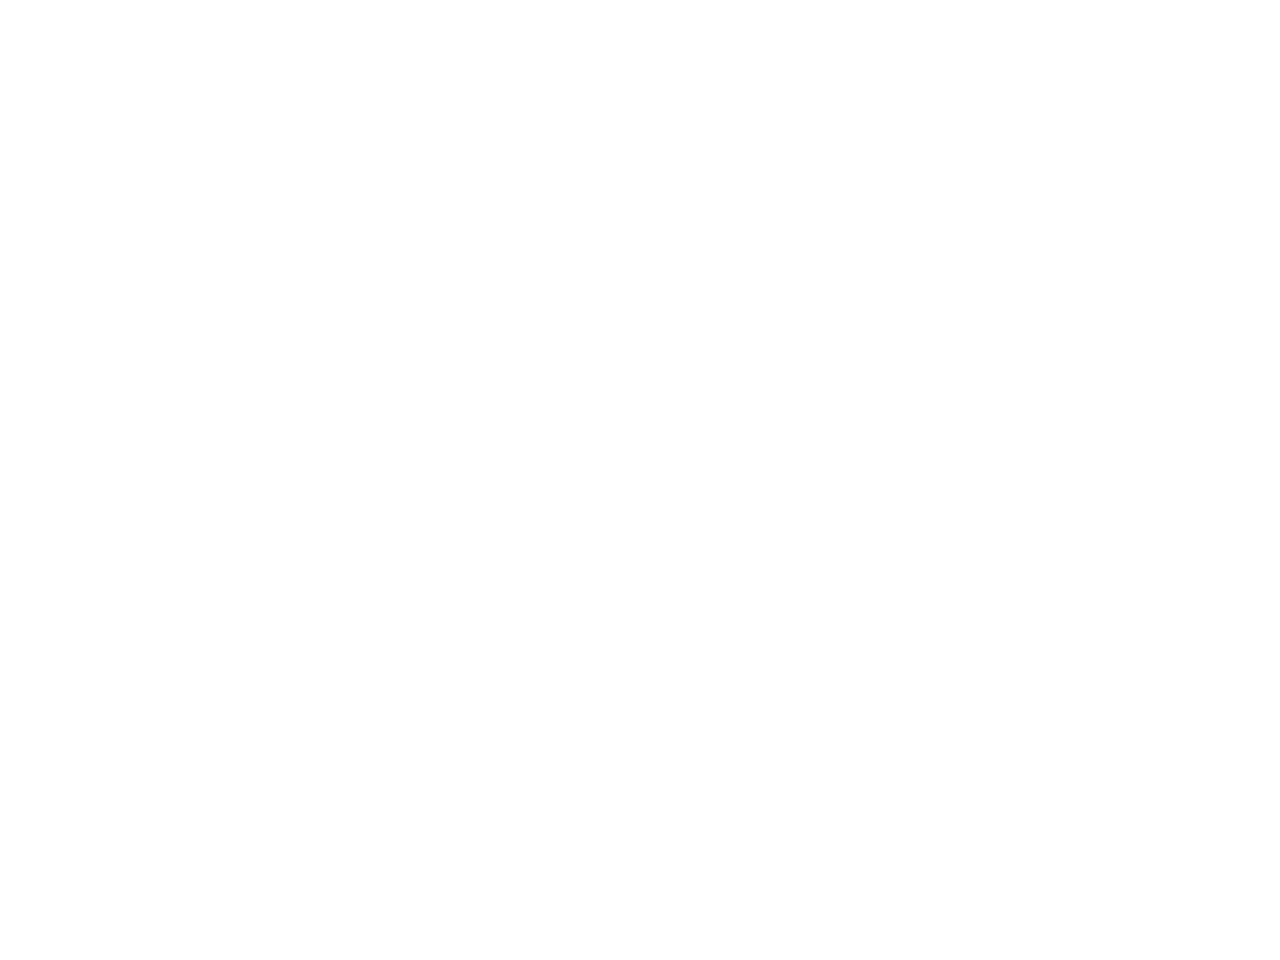

In [26]:
fold = 4

plt.rcParams['figure.figsize'] = [6, 4]

%matplotlib notebook
plt.plot(histories[fold].history['accuracy'])
plt.plot(histories[fold].history['val_accuracy'])
plt.ylim((0.98, 1.0))
plt.axhline(y=0.74, color='r', linestyle='-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
print('ACCURACY')
print('cnn1 acc =', round(np.mean(cnn1['acc']), 3))
print('cnn1 emr =', round(np.mean(cnn1['emr']), 3))
print('')

ACCURACY
cnn1 acc = 0.985
cnn1 emr = 0.676



64,  128, 125,  0.5 = 0.984, 0.634
128, 128, 125,  0.5 = 0.984, 0.668
128, 128, 175,  0.5 = 0.985, 0.673
128, 128, 250,  0.5 = 0.985, 0.678
128, 128, 300,  0.5 = 0.985, 0.671
128, 128, 500,  0.5 = 0.986, 0.676
64,  64,  500,  0.5 = 0.985, 0.675
64,  64,  750,  0.5 = 0.985, 0.680 ***
32,  32,  1000, 0.5 = 0.985, 0.673
32,  32,  500,  0.4 = 0.985, 0.679
32,  32,  500,  0.3 = 0.985, 0.679
32,  32,  700,  0.3 = 0.985, 0.676
32,  32, 1000,  0.3 = 0.985, 0.674
8,   64, 1000,  0.3 = 0.985, 0.665
8,   64, 1000,  0.5 = 0.985, 0.663

In [28]:
row = 8

y_val = np.concatenate(y_val_list)
probs = np.concatenate(probs_list)
print(np.sum(probs[row]))
plt.rcParams['figure.figsize'] = [9, 6]
#target = y_val[row]
#target_name = list(label_dict.keys())[list(label_dict.values()).index(target)]

%matplotlib notebook
fig, ax1 = plt.subplots(1)
barlist = ax1.bar(np.arange(len(unique_topics)), probs[row], color='blue', edgecolor='black', alpha=0.5)

for i in range(len(unique_topics)):
    if y_val[row, i] == 1.:
        barlist[i].set_color('red')
ax1.set_ylabel('Probability')
ax1.set_xticks(np.arange(len(unique_topics)))
#ax1.set_xticklabels(np.arange(len(unique_topics)), rotation = 90)
plt.tight_layout()
plt.show()

0.17702925


<IPython.core.display.Javascript object>

---

### Train on all labeled data

In [30]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 64
HIDDEN_DIMS = 64
EPOCHS = 750
DROPOUT_RATE = 0.5

  
y_val = category
texts_val = texts
y_train = category
texts_train = texts

x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, 
                                                                             texts_train, MAX_SEQUENCE_LENGTH)

# y_val, y_train = y_to_int(category_val, category_train, label_dict)

# print('Validation data shape =', x_val.shape)
# print('Train data shape =', x_train.shape)

# print('Validation labels shape =', y_val.shape)
# print('Train labels shape =', y_train.shape)

embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

model, acc, emr, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                   EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                   x_train, y_train, x_val, y_val, 
                                                   word_index, embedding_matrix, verbose=False)

CNN validation accuracy: 0.999
Exact match ratio: 0.966


In [31]:
def apply_trained_model(df, model, MAX_SEQUENCE_LENGTH, tokenizer, labels):
    print(f'The data has {df.shape[0]} rows.')

    # convert the text col to a numpy array
    texts = np.array(df['user_desc']).astype(str)

    sequences = tokenizer.texts_to_sequences(texts)
    x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # convert text to the required input format
    #_, x, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, None, texts, MAX_SEQUENCE_LENGTH)

    # apply trained model and get predictions
    probs = model.predict(x, batch_size=BATCH_SIZE, verbose=False)
    
    for i in range(len(labels)):
        df['prob_' + labels[i]] = probs[:, i]
    
    return df

In [32]:
df1 = pd.read_csv('data_raw/results_feralswine_05012019to11042019.csv')
df2 = pd.read_csv('data_raw/results_wildpigs_05012019to11042019.csv')
df3 = pd.read_csv('data_raw/results_wildhogs_05012019to11042019.csv')

# add sentiment
df1 = apply_trained_model(df1, model, MAX_SEQUENCE_LENGTH, tokenizer, unique_topics)
df2 = apply_trained_model(df2, model, MAX_SEQUENCE_LENGTH, tokenizer, unique_topics)
df3 = apply_trained_model(df3, model, MAX_SEQUENCE_LENGTH, tokenizer, unique_topics)

# write to disk
df1.to_csv('data_raw/results_feralswine_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df2.to_csv('data_raw/results_wildpigs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df3.to_csv('data_raw/results_wildhogs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

/Users/ama/NWRC/Venv/cnn-nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data has 3622 rows.
The data has 19661 rows.
The data has 25274 rows.


In [33]:
df = pd.concat([df1, df2, df3])
for col in unique_topics:
    name = 'prob_' + col
    print(f'{col}: {round(df[name].sum() / df.shape[0], 2)}')

Parent: 0.02
Spouse: 0.01
Male: 0.04
Female: 0.04
They: 0.01
Conservative Ideology: 0.0
Liberal Ideology: 0.0
White: 0.0
Asian: 0.0
Native American: 0.0
Black/African American: 0.0
Latino: 0.0
LGBTQ: 0.01
Religious: 0.0
Pro-Environment: 0.0
Anti-Environment: 0.0
Animal Advocate: 0.01
Outdoorsman/women: 0.0
Pro-Guns: 0.0
Politics: 0.0
Government Organizations: 0.0
Pro-Trump: 0.0
Anti-Trump: 0.0
Wild pigs: 0.0
Academic: 0.01
Business and Computers: 0.0
Criminal Justice, Political Science, and Legal Aid: 0.0
Journalism and Media Communication: 0.04
Life & Natural Science: 0.0
Healthcare: 0.0
Armed Forces: 0.0
Natural Resources: 0.01
Agriculture: 0.0


/Users/ama/NWRC/Venv/cnn-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
